In [1]:
# Cell 1: Imports and Setup
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights

import cv2

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(42)

# Device configuration
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple MPS")
else:
    device = torch.device('cpu')
    print("Using CPU")

print(f"Device: {device}")

Using Apple MPS
Device: mps


In [2]:
# Cell 2: Configuration
class Config:
    # Paths
    BASE_DIR = '/Users/yashbansal/Documents/cdc/Approach_3'
    DATA_DIR = os.path.join(BASE_DIR, 'data')
    PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')
    RAW_DIR = os.path.join(DATA_DIR, 'raw')
    TEST_IMG_DIR = os.path.join(DATA_DIR, 'test_data_images')
    
    # Image paths - Training images (used for both train and val)
    TRAIN_IMG_19 = os.path.join(RAW_DIR, 'train_images_19')
    TRAIN_IMG_20 = os.path.join(RAW_DIR, 'train_images_20')
    
    # Test images
    TEST_IMG_19 = os.path.join(TEST_IMG_DIR, 'test_images_19')
    TEST_IMG_20 = os.path.join(TEST_IMG_DIR, 'test_images_20')
    
    # Output paths
    OUTPUT_DIR = os.path.join(BASE_DIR, 'outputs')
    EXPLAINABILITY_DIR = os.path.join(BASE_DIR, 'Explainability')
    MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, 'best_model.pth')
    PREDICTIONS_PATH = os.path.join(OUTPUT_DIR, 'test_predictions.csv')
    
    # Model architecture
    IMG_SIZE = 224  # Resize from 1280 to 224
    ORIGINAL_IMG_SIZE = 1280
    
    # Tabular Transformer
    TAB_D_MODEL = 128
    TAB_NHEAD = 4
    TAB_NUM_LAYERS = 2
    TAB_OUTPUT_DIM = 128
    
    # Cross-modal attention
    ATTENTION_DIM = 256
    ATTENTION_HEADS = 4
    
    # Fusion MLP
    FUSION_HIDDEN = [768, 384, 128]
    DROPOUT = 0.2
    
    # Training
    BATCH_SIZE = 32
    EPOCHS = 40
    LR_MAIN = 3e-4
    LR_BACKBONE = 4e-5
    WEIGHT_DECAY = 1e-5
    WARMUP_EPOCHS = 5
    EARLY_STOPPING_PATIENCE = 15
    
    # Loss
    HUBER_DELTA = 1.0
    
    # Freeze 75% of ResNet, unfreeze 25%
    FREEZE_PERCENT = 0.75

config = Config()

# Create output directories
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.EXPLAINABILITY_DIR, exist_ok=True)
os.makedirs(os.path.join(config.EXPLAINABILITY_DIR, 'validation'), exist_ok=True)
os.makedirs(os.path.join(config.EXPLAINABILITY_DIR, 'test'), exist_ok=True)

print("Configuration loaded successfully!")
print(f"Output directory: {config.OUTPUT_DIR}")
print(f"Explainability directory: {config.EXPLAINABILITY_DIR}")

Configuration loaded successfully!
Output directory: /Users/yashbansal/Documents/cdc/Approach_3/outputs
Explainability directory: /Users/yashbansal/Documents/cdc/Approach_3/Explainability


In [3]:
# Cell 3: Load and Explore Data
# Load CSV files
train_df = pd.read_csv(os.path.join(config.PROCESSED_DIR, 'train_processed.csv'))
val_df = pd.read_csv(os.path.join(config.PROCESSED_DIR, 'val_processed.csv'))
test_df = pd.read_csv(os.path.join(config.PROCESSED_DIR, 'test_processed.csv'))

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTrain columns: {train_df.columns.tolist()}")
print(f"\nTest columns: {test_df.columns.tolist()}")
print(f"\nTrain head:\n{train_df.head(2)}")

Train samples: 12967
Validation samples: 3242
Test samples: 5404

Train columns: ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log', 'property_age', 'was_renovated', 'years_since_renovation', 'has_basement', 'total_rooms', 'has_view', 'is_luxury', 'distance_from_seattle', 'price_log', 'price', 'id', 'lat', 'long', 'image_exists', 'image_path']

Test columns: ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log', 'property_age', 'was_renovated', 'years_since_renovation', 'has_basement', 'total_rooms', 'has_view', 'is_luxury', 'distance_from_seattle', 'id', 'lat', 'long', 'image_path', 'image_exists']

Train head:
   bedrooms  bathrooms    floors  waterfront      view  condition     grade  \
0 -0.404751   0.507395

In [4]:
# Cell 4: Define Feature Columns
# Columns to exclude (metadata and target)
EXCLUDE_COLS = ['id', 'lat', 'long', 'image_exists', 'image_path', 'price', 'price_log']

# Get feature columns (all columns except excluded ones)
TABULAR_FEATURES = [col for col in train_df.columns if col not in EXCLUDE_COLS]
NUM_FEATURES = len(TABULAR_FEATURES)

print(f"Number of tabular features: {NUM_FEATURES}")
print(f"Features: {TABULAR_FEATURES}")

# Target column - using price_log which is already computed
TARGET_COL = 'price_log'
print(f"\nTarget column: {TARGET_COL}")
print(f"Target stats - Min: {train_df[TARGET_COL].min():.4f}, Max: {train_df[TARGET_COL].max():.4f}, Mean: {train_df[TARGET_COL].mean():.4f}")

Number of tabular features: 21
Features: ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_living_log', 'sqft_lot_log', 'sqft_above_log', 'sqft_basement_log', 'sqft_living15_log', 'sqft_lot15_log', 'property_age', 'was_renovated', 'years_since_renovation', 'has_basement', 'total_rooms', 'has_view', 'is_luxury', 'distance_from_seattle']

Target column: price_log
Target stats - Min: 11.2252, Max: 15.8567, Mean: 13.0461


In [7]:
# Cell 5: Image Transforms
# Training transforms (with mild augmentation - preserve geography)
train_transform = T.Compose([
    T.Resize((config.IMG_SIZE, config.IMG_SIZE)),  # Resize from 1280 to 224
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomApply([T.RandomRotation(degrees=[90, 90])], p=0.25),
    T.RandomApply([T.RandomRotation(degrees=[180, 180])], p=0.25),
    T.RandomApply([T.RandomRotation(degrees=[270, 270])], p=0.25),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation)
val_transform = T.Compose([
    T.Resize((config.IMG_SIZE, config.IMG_SIZE)),  # Resize from 1280 to 224
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms defined!")
print(f"Images will be resized from {config.ORIGINAL_IMG_SIZE}x{config.ORIGINAL_IMG_SIZE} to {config.IMG_SIZE}x{config.IMG_SIZE}")

Transforms defined!
Images will be resized from 1280x1280 to 224x224


In [5]:
# Cell 6: Dataset Class
class MultiScalePropertyDataset(Dataset):
    """Dataset for multi-scale satellite imagery property valuation."""
    
    def __init__(self, df, img_dir_19, img_dir_20, features, target_col=None, transform=None, is_test=False):
        self.df = df.reset_index(drop=True)
        self.img_dir_19 = img_dir_19
        self.img_dir_20 = img_dir_20
        self.features = features
        self.target_col = target_col
        self.transform = transform
        self.is_test = is_test
        
        # Pre-compute valid indices (samples with both images)
        self.valid_indices = []
        missing_count = 0
        
        for idx in range(len(self.df)):
            prop_id = self.df.loc[idx, 'id']
            img_path_19 = os.path.join(self.img_dir_19, f"{prop_id}_z19.jpg")
            img_path_20 = os.path.join(self.img_dir_20, f"{prop_id}_z20.jpg")
            
            if os.path.exists(img_path_19) and os.path.exists(img_path_20):
                self.valid_indices.append(idx)
            else:
                missing_count += 1
        
        print(f"Dataset initialized: {len(self.valid_indices)}/{len(self.df)} samples have both zoom images")
        if missing_count > 0:
            print(f"  Missing images for {missing_count} samples")
    
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        row = self.df.iloc[actual_idx]
        prop_id = row['id']
        
        # Load images (naming: {id}_z19.jpg and {id}_z20.jpg)
        img_path_19 = os.path.join(self.img_dir_19, f"{prop_id}_z19.jpg")
        img_path_20 = os.path.join(self.img_dir_20, f"{prop_id}_z20.jpg")
        
        img_19 = Image.open(img_path_19).convert('RGB')
        img_20 = Image.open(img_path_20).convert('RGB')
        
        if self.transform:
            # Use same random seed for both images to apply same augmentation
            seed = random.randint(0, 2**32)
            random.seed(seed)
            torch.manual_seed(seed)
            img_19 = self.transform(img_19)
            random.seed(seed)
            torch.manual_seed(seed)
            img_20 = self.transform(img_20)
        
        # Tabular features
        tabular = torch.tensor(row[self.features].values.astype(np.float32), dtype=torch.float32)
        
        # Property ID for tracking
        prop_id_int = int(prop_id)
        
        if self.is_test:
            return img_19, img_20, tabular, prop_id_int
        else:
            # Target is price_log (already log-transformed)
            target = torch.tensor(row[self.target_col], dtype=torch.float32)
            return img_19, img_20, tabular, target, prop_id_int

print("Dataset class defined!")

Dataset class defined!


In [8]:
# Cell 7: Create Datasets and DataLoaders
# Training dataset - uses train_images_19 and train_images_20
train_dataset = MultiScalePropertyDataset(
    df=train_df,
    img_dir_19=config.TRAIN_IMG_19,
    img_dir_20=config.TRAIN_IMG_20,
    features=TABULAR_FEATURES,
    target_col=TARGET_COL,
    transform=train_transform,
    is_test=False
)

# Validation dataset - also uses train_images_19 and train_images_20 (same source as train)
val_dataset = MultiScalePropertyDataset(
    df=val_df,
    img_dir_19=config.TRAIN_IMG_19,
    img_dir_20=config.TRAIN_IMG_20,
    features=TABULAR_FEATURES,
    target_col=TARGET_COL,
    transform=val_transform,
    is_test=False
)

# Test dataset - uses test_images_19 and test_images_20
test_dataset = MultiScalePropertyDataset(
    df=test_df,
    img_dir_19=config.TEST_IMG_19,
    img_dir_20=config.TEST_IMG_20,
    features=TABULAR_FEATURES,
    target_col=None,
    transform=val_transform,
    is_test=True
)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Dataset initialized: 12967/12967 samples have both zoom images
Dataset initialized: 3242/3242 samples have both zoom images
Dataset initialized: 5404/5404 samples have both zoom images

Train batches: 406
Validation batches: 102
Test batches: 169


In [9]:
# Cell 8: Tabular Transformer Encoder
class TabularTransformer(nn.Module):
    """Transformer-based encoder for tabular features."""
    
    def __init__(self, num_features, d_model=128, nhead=4, num_layers=2, output_dim=128):
        super().__init__()
        self.num_features = num_features
        self.d_model = d_model
        
        # Project each feature to d_model dimension
        self.feature_embedding = nn.Linear(1, d_model)
        
        # Learnable positional encoding for each feature
        self.pos_encoding = nn.Parameter(torch.randn(1, num_features, d_model) * 0.02)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_proj = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, output_dim),
            nn.GELU()
        )
    
    def forward(self, x):
        # x: (B, num_features)
        B = x.size(0)
        
        # Reshape to (B, num_features, 1) and embed each feature
        x = x.unsqueeze(-1)  # (B, num_features, 1)
        x = self.feature_embedding(x)  # (B, num_features, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding
        
        # Transformer encoding
        x = self.transformer(x)  # (B, num_features, d_model)
        
        # Global average pooling over features
        x = x.mean(dim=1)  # (B, d_model)
        
        # Output projection
        x = self.output_proj(x)  # (B, output_dim)
        
        return x

print("TabularTransformer defined!")

TabularTransformer defined!


In [10]:
# Cell 9: Visual Backbone (ResNet-50 with 25% unfreezing)
class VisualBackbone(nn.Module):
    """ResNet50 backbone that extracts multi-scale features from layer3 and layer4.
    Freezes 75% of the backbone, unfreezes 25% (layer3, layer4)."""
    
    def __init__(self):
        super().__init__()
        
        # Load pretrained ResNet50
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        
        # Extract layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1  # 256 channels
        self.layer2 = resnet.layer2  # 512 channels
        self.layer3 = resnet.layer3  # 1024 channels, 14x14 for 224 input
        self.layer4 = resnet.layer4  # 2048 channels, 7x7 for 224 input
        
        # Projection layers for multi-scale features
        self.proj3 = nn.Sequential(
            nn.Conv2d(1024, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.proj4 = nn.Sequential(
            nn.Conv2d(2048, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Final projection after concatenation
        self.final_proj = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Freeze 75% of ResNet (conv1, bn1, layer1, layer2)
        self._freeze_layers()
    
    def _freeze_layers(self):
        """Freeze conv1, bn1, layer1, layer2 (approximately 75% of backbone)."""
        # Freeze these layers
        frozen_layers = [self.conv1, self.bn1, self.layer1, self.layer2,self.layer3]
        for layer in frozen_layers:
            for param in layer.parameters():
                param.requires_grad = False
        
        # Keep layer3, layer4, and projection layers trainable (25%)
        trainable_layers = [ self.layer4, self.proj3, self.proj4, self.final_proj]
        for layer in trainable_layers:
            for param in layer.parameters():
                param.requires_grad = True
    
    def forward(self, x):
        # Initial layers (frozen)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # ResNet blocks
        x = self.layer1(x)  # Frozen
        x = self.layer2(x)  # Frozen
        feat3 = self.layer3(x)  # Trainable - (B, 1024, 14, 14)
        feat4 = self.layer4(feat3)  # Trainable - (B, 2048, 7, 7)
        
        # Project features
        proj3 = self.proj3(feat3)  # (B, 256, 14, 14)
        proj4 = self.proj4(feat4)  # (B, 256, 7, 7)
        
        # Upsample proj4 to match proj3 spatial size
        proj4_up = F.interpolate(proj4, size=(14, 14), mode='bilinear', align_corners=False)
        
        # Concatenate and project
        combined = torch.cat([proj3, proj4_up], dim=1)  # (B, 512, 14, 14)
        img_feats = self.final_proj(combined)  # (B, 256, 14, 14)
        
        return img_feats, feat4  # Return both for Grad-CAM

print("VisualBackbone defined (75% frozen, 25% trainable)!")

VisualBackbone defined (75% frozen, 25% trainable)!


In [11]:
# Cell 10: Cross-Modal Attention Module
class CrossModalAttention(nn.Module):
    """Cross-modal attention where tabular context queries image features."""
    
    def __init__(self, tab_dim=128, img_dim=256, embed_dim=256, num_heads=4):
        super().__init__()
        self.embed_dim = embed_dim
        
        # Project tabular to query dimension
        self.query_proj = nn.Linear(tab_dim, embed_dim)
        
        # Project image features to key/value dimension
        self.key_proj = nn.Linear(img_dim, embed_dim)
        self.value_proj = nn.Linear(img_dim, embed_dim)
        
        # Multi-head attention
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=0.1,
            batch_first=True
        )
        
        # Layer norm and output projection
        self.norm = nn.LayerNorm(embed_dim)
        self.output_proj = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU()
        )
    
    def forward(self, tab_ctx, img_feats, return_attention=False):
        """
        Args:
            tab_ctx: (B, tab_dim) - tabular context vector
            img_feats: (B, 256, 14, 14) - image feature maps
            return_attention: whether to return attention weights
        Returns:
            attended: (B, embed_dim) - attended image features
            attn_weights: (B, 1, 196) - attention weights if return_attention=True
        """
        B = tab_ctx.size(0)
        
        # Flatten spatial dimensions: (B, 256, 14, 14) -> (B, 196, 256)
        img_feats_flat = img_feats.flatten(2).permute(0, 2, 1)  # (B, 196, 256)
        
        # Project to query, key, value
        Q = self.query_proj(tab_ctx).unsqueeze(1)  # (B, 1, embed_dim)
        K = self.key_proj(img_feats_flat)  # (B, 196, embed_dim)
        V = self.value_proj(img_feats_flat)  # (B, 196, embed_dim)
        
        # Cross-attention
        attended, attn_weights = self.attention(Q, K, V, need_weights=True, average_attn_weights=True)
        # attended: (B, 1, embed_dim), attn_weights: (B, 1, 196)
        
        # Squeeze and process
        attended = attended.squeeze(1)  # (B, embed_dim)
        attended = self.norm(attended)
        attended = self.output_proj(attended)  # (B, embed_dim)
        
        if return_attention:
            return attended, attn_weights
        return attended, None

print("CrossModalAttention defined!")

CrossModalAttention defined!


In [12]:
# Cell 11: Main Model
class MultiScalePropertyModel(nn.Module):
    """Multi-scale property valuation model with cross-modal attention fusion."""
    
    def __init__(self, num_features, config):
        super().__init__()
        
        # Tabular encoder
        self.tabular_encoder = TabularTransformer(
            num_features=num_features,
            d_model=config.TAB_D_MODEL,
            nhead=config.TAB_NHEAD,
            num_layers=config.TAB_NUM_LAYERS,
            output_dim=config.TAB_OUTPUT_DIM
        )
        
        # Shared visual backbone for both zoom levels
        self.visual_backbone = VisualBackbone()
        
        # Cross-modal attention for each zoom level
        self.cross_attn_19 = CrossModalAttention(
            tab_dim=config.TAB_OUTPUT_DIM,
            img_dim=config.ATTENTION_DIM,
            embed_dim=config.ATTENTION_DIM,
            num_heads=config.ATTENTION_HEADS
        )
        
        self.cross_attn_20 = CrossModalAttention(
            tab_dim=config.TAB_OUTPUT_DIM,
            img_dim=config.ATTENTION_DIM,
            embed_dim=config.ATTENTION_DIM,
            num_heads=config.ATTENTION_HEADS
        )
        
        # Project tabular context for fusion
        self.tab_proj = nn.Linear(config.TAB_OUTPUT_DIM, config.ATTENTION_DIM)
        
        # Fusion MLP: [tab_ctx(256) + attended_19(256) + attended_20(256)] = 768
        fusion_input_dim = config.ATTENTION_DIM * 3
        self.fusion_head = nn.Sequential(
            nn.Linear(fusion_input_dim, config.FUSION_HIDDEN[1]),
            nn.LayerNorm(config.FUSION_HIDDEN[1]),
            nn.GELU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.FUSION_HIDDEN[1], config.FUSION_HIDDEN[2]),
            nn.LayerNorm(config.FUSION_HIDDEN[2]),
            nn.GELU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.FUSION_HIDDEN[2], 1)
        )
        
        # Store intermediate features for Grad-CAM
        self.feat4_19 = None
        self.feat4_20 = None
    
    def forward(self, img_19, img_20, tabular, return_attention=False):
        """
        Args:
            img_19: (B, 3, 224, 224) - zoom 19 images
            img_20: (B, 3, 224, 224) - zoom 20 images
            tabular: (B, num_features) - tabular features
            return_attention: whether to return attention weights
        """
        # Encode tabular features
        tab_ctx = self.tabular_encoder(tabular)  # (B, 128)
        
        # Extract visual features for both zoom levels (shared backbone)
        img_feats_19, self.feat4_19 = self.visual_backbone(img_19)  # (B, 256, 14, 14)
        img_feats_20, self.feat4_20 = self.visual_backbone(img_20)  # (B, 256, 14, 14)
        
        # Cross-modal attention
        attended_19, attn_19 = self.cross_attn_19(tab_ctx, img_feats_19, return_attention)
        attended_20, attn_20 = self.cross_attn_20(tab_ctx, img_feats_20, return_attention)
        
        # Project tabular context
        tab_ctx_proj = self.tab_proj(tab_ctx)  # (B, 256)
        
        # Concatenate all features
        fused = torch.cat([tab_ctx_proj, attended_19, attended_20], dim=1)  # (B, 768)
        
        # Predict log(price)
        output = self.fusion_head(fused).squeeze(-1)  # (B,)
        
        if return_attention:
            return output, attn_19, attn_20
        return output

print("MultiScalePropertyModel defined!")

MultiScalePropertyModel defined!


In [13]:
# Cell 12: Initialize Model and Check Parameters
model = MultiScalePropertyModel(num_features=NUM_FEATURES, config=config)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
print(f"Frozen parameters: {frozen_params:,} ({100*frozen_params/total_params:.1f}%)")

# Test forward pass
with torch.no_grad():
    test_img = torch.randn(2, 3, 224, 224).to(device)
    test_tab = torch.randn(2, NUM_FEATURES).to(device)
    out, attn_19, attn_20 = model(test_img, test_img, test_tab, return_attention=True)
    print(f"\nTest forward pass:")
    print(f"  Output shape: {out.shape}")
    print(f"  Attention 19 shape: {attn_19.shape}")
    print(f"  Attention 20 shape: {attn_20.shape}")

Total parameters: 26,211,009
Trainable parameters: 17,667,713 (67.4%)
Frozen parameters: 8,543,296 (32.6%)

Test forward pass:
  Output shape: torch.Size([2])
  Attention 19 shape: torch.Size([2, 1, 196])
  Attention 20 shape: torch.Size([2, 1, 196])


In [14]:
# Cell 13: Loss Function, Optimizer, and Scheduler
# Huber Loss on log(price)
criterion = nn.HuberLoss(delta=config.HUBER_DELTA)

# Separate parameter groups for different learning rates
backbone_params = []
other_params = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if 'visual_backbone' in name and ('layer3' in name or 'layer4' in name):
            backbone_params.append(param)
        else:
            other_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': backbone_params, 'lr': config.LR_BACKBONE},
    {'params': other_params, 'lr': config.LR_MAIN}
], weight_decay=config.WEIGHT_DECAY)

# Cosine annealing scheduler with warmup
def get_lr_scheduler(optimizer, warmup_epochs, total_epochs, min_lr=1e-5):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (epoch + 1) / warmup_epochs
        else:
            progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
            return max(min_lr / config.LR_MAIN, 0.5 * (1 + np.cos(np.pi * progress)))
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_lr_scheduler(optimizer, config.WARMUP_EPOCHS, config.EPOCHS)

print(f"Backbone params (lr={config.LR_BACKBONE}): {sum(p.numel() for p in backbone_params):,}")
print(f"Other params (lr={config.LR_MAIN}): {sum(p.numel() for p in other_params):,}")
print("Optimizer and scheduler configured!")

Backbone params (lr=4e-05): 14,964,736
Other params (lr=0.0003): 2,702,977
Optimizer and scheduler configured!


In [15]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Training")
    for batch in pbar:
        img_19, img_20, tabular, targets, _ = batch

        img_19 = img_19.to(device)
        img_20 = img_20.to(device)
        tabular = tabular.to(device)
        targets = targets.to(device)   # log(price)

        optimizer.zero_grad()

        outputs = model(img_19, img_20, tabular).squeeze()
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * targets.size(0)

        all_preds.append(outputs.detach().cpu())
        all_targets.append(targets.detach().cpu())

        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # ---- Epoch metrics (LOG SPACE) ----
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()

    rmse_log = np.sqrt(np.mean((all_preds - all_targets) ** 2))
    r2_log = 1 - np.sum((all_preds - all_targets) ** 2) / np.sum(
        (all_targets - np.mean(all_targets)) ** 2
    )

    avg_loss = total_loss / len(loader.dataset)

    return avg_loss, rmse_log, r2_log
@torch.no_grad()
def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_targets = []
    all_ids = []

    for batch in tqdm(loader, desc="Validating"):
        img_19, img_20, tabular, targets, prop_ids = batch

        img_19 = img_19.to(device)
        img_20 = img_20.to(device)
        tabular = tabular.to(device)
        targets = targets.to(device)   # log(price)

        outputs = model(img_19, img_20, tabular).squeeze()
        loss = criterion(outputs, targets)

        total_loss += loss.item() * targets.size(0)

        all_preds.append(outputs.cpu())
        all_targets.append(targets.cpu())
        all_ids.append(prop_ids)

    # ---- Epoch metrics (LOG SPACE) ----
    all_preds = torch.cat(all_preds).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_ids = torch.cat(all_ids).numpy()

    rmse_log = np.sqrt(np.mean((all_preds - all_targets) ** 2))
    r2_log = 1 - np.sum((all_preds - all_targets) ** 2) / np.sum(
        (all_targets - np.mean(all_targets)) ** 2
    )

    avg_loss = total_loss / len(loader.dataset)

    return avg_loss, rmse_log, r2_log, all_preds, all_targets, all_ids


In [16]:
# Cell 15: Grad-CAM Implementation
class GradCAM:
    """Grad-CAM implementation for ResNet layer4."""
    
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.activations = None
    
    def get_cam(self, input_img_19, input_img_20, tabular, zoom_level='19'):
        """Generate Grad-CAM heatmap for specified zoom level."""
        self.model.eval()
        
        # Enable gradients for input
        input_img_19.requires_grad_(True)
        input_img_20.requires_grad_(True)
        
        # Forward pass
        output = self.model(input_img_19, input_img_20, tabular)
        
        # Get the target feature map
        if zoom_level == '19':
            target_layer = self.model.feat4_19
        else:
            target_layer = self.model.feat4_20
        
        # Register hook for gradients
        target_layer.retain_grad()
        
        # Backward pass
        self.model.zero_grad()
        output.backward(retain_graph=True)
        
        # Get gradients and activations
        gradients = target_layer.grad  # (B, C, H, W)
        activations = target_layer  # (B, C, H, W)
        
        # Pool gradients across spatial dimensions
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)  # (B, C, 1, 1)
        
        # Weighted combination of activation maps
        cam = torch.sum(weights * activations, dim=1)  # (B, H, W)
        
        # ReLU and normalize
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam.detach().cpu().numpy()

print("GradCAM class defined!")

GradCAM class defined!


In [17]:
# Cell 16: Visualization Functions
def create_heatmap_overlay(img, heatmap, alpha=0.5):
    """Create heatmap overlay on image."""
    # Resize heatmap to match image
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert heatmap to colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    
    # Overlay
    overlay = alpha * heatmap_colored + (1 - alpha) * img
    overlay = np.clip(overlay, 0, 1)
    
    return overlay

def visualize_explainability(model, img_19, img_20, tabular, prop_id, save_dir, prefix='val'):
    """Generate and save Grad-CAM and attention visualizations."""
    model.eval()
    
    # Clone tensors and enable gradients for Grad-CAM
    img_19_input = img_19.clone().requires_grad_(True)
    img_20_input = img_20.clone().requires_grad_(True)
    
    # Forward pass with attention
    output, attn_19, attn_20 = model(img_19_input, img_20_input, tabular, return_attention=True)
    
    # Get attention maps (reshape from (B, 1, 196) to (14, 14))
    attn_map_19 = attn_19.squeeze(1).reshape(-1, 14, 14).detach().cpu().numpy()[0]
    attn_map_20 = attn_20.squeeze(1).reshape(-1, 14, 14).detach().cpu().numpy()[0]
    
    # Normalize attention maps
    attn_map_19 = (attn_map_19 - attn_map_19.min()) / (attn_map_19.max() - attn_map_19.min() + 1e-8)
    attn_map_20 = (attn_map_20 - attn_map_20.min()) / (attn_map_20.max() - attn_map_20.min() + 1e-8)
    
    # Get Grad-CAM for zoom 19
    gradcam = GradCAM(model)
    img_19_grad = img_19.clone().requires_grad_(True)
    img_20_grad = img_20.clone().requires_grad_(True)
    cam_19 = gradcam.get_cam(img_19_grad, img_20_grad, tabular, zoom_level='19')[0]
    
    # Get Grad-CAM for zoom 20
    img_19_grad2 = img_19.clone().requires_grad_(True)
    img_20_grad2 = img_20.clone().requires_grad_(True)
    cam_20 = gradcam.get_cam(img_19_grad2, img_20_grad2, tabular, zoom_level='20')[0]
    
    # Convert images to numpy for visualization (denormalize)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img_19_np = img_19.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img_19_np = std * img_19_np + mean
    img_19_np = np.clip(img_19_np, 0, 1)
    
    img_20_np = img_20.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    img_20_np = std * img_20_np + mean
    img_20_np = np.clip(img_20_np, 0, 1)
    
    # Create overlays
    gradcam_overlay_19 = create_heatmap_overlay(img_19_np, cam_19)
    attn_overlay_19 = create_heatmap_overlay(img_19_np, attn_map_19)
    gradcam_overlay_20 = create_heatmap_overlay(img_20_np, cam_20)
    attn_overlay_20 = create_heatmap_overlay(img_20_np, attn_map_20)
    
    # Create figure: 2 rows (zoom levels) x 3 cols (original, gradcam, attention)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Zoom 19
    axes[0, 0].imshow(img_19_np)
    axes[0, 0].set_title('Zoom 19 - Original')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(gradcam_overlay_19)
    axes[0, 1].set_title('Zoom 19 - Grad-CAM')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(attn_overlay_19)
    axes[0, 2].set_title('Zoom 19 - Attention')
    axes[0, 2].axis('off')
    
    # Zoom 20
    axes[1, 0].imshow(img_20_np)
    axes[1, 0].set_title('Zoom 20 - Original')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(gradcam_overlay_20)
    axes[1, 1].set_title('Zoom 20 - Grad-CAM')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(attn_overlay_20)
    axes[1, 2].set_title('Zoom 20 - Attention')
    axes[1, 2].axis('off')
    
    pred_price = np.exp(output.item())
    fig.suptitle(f'Property ID: {prop_id} | Predicted Price: ${pred_price:,.0f}', fontsize=14)
    
    plt.tight_layout()
    save_path = os.path.join(save_dir, f'{prefix}_{prop_id}_explainability.png')
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    return save_path

print("Visualization functions defined!")

Visualization functions defined!


In [18]:
# Cell 17: Training Loop (FIXED)

history = {
    'train_loss': [], 'val_loss': [],
    'train_rmse_log': [], 'val_rmse_log': [],
    'train_r2_log': [], 'val_r2_log': [],
    'lr': []
}

best_val_rmse_log = float('inf')
patience_counter = 0

print(f"Starting training for {config.EPOCHS} epochs...")
print(f"Early stopping patience: {config.EARLY_STOPPING_PATIENCE}")
print("=" * 60)

for epoch in range(config.EPOCHS):
    current_lr = optimizer.param_groups[1]['lr']
    print(f"\nEpoch {epoch+1}/{config.EPOCHS} | LR: {current_lr:.2e}")

    # ---- Training ----
    train_loss, train_rmse_log, train_r2_log = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # ---- Validation ----
    val_loss, val_rmse_log, val_r2_log, _, _, _ = validate(
        model, val_loader, criterion, device
    )

    scheduler.step()

    # ---- Store history ----
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_rmse_log'].append(train_rmse_log)
    history['val_rmse_log'].append(val_rmse_log)
    history['train_r2_log'].append(train_r2_log)
    history['val_r2_log'].append(val_r2_log)
    history['lr'].append(current_lr)

    # ---- Print LOG-space metrics ----
    print(
        f"  Train | Loss: {train_loss:.4f} | RMSE_log: {train_rmse_log:.4f} | R²_log: {train_r2_log:.4f}"
    )
    print(
        f"  Val   | Loss: {val_loss:.4f} | RMSE_log: {val_rmse_log:.4f} | R²_log: {val_r2_log:.4f}"
    )

    # ---- Early stopping on LOG RMSE ----
    if val_rmse_log < best_val_rmse_log:
        best_val_rmse_log = val_rmse_log
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_rmse_log': val_rmse_log,
            'val_r2_log': val_r2_log,
            'history': history
        }, config.MODEL_SAVE_PATH)

        print(f"  ✓ New best model saved! RMSE_log: {best_val_rmse_log:.4f}")

    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{config.EARLY_STOPPING_PATIENCE}")

    if patience_counter >= config.EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered at epoch {epoch+1}")
        break

print("\n" + "=" * 60)
print(f"Training complete! Best validation RMSE_log: {best_val_rmse_log:.4f}")


Starting training for 40 epochs...
Early stopping patience: 15

Epoch 1/40 | LR: 6.00e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 8.2224 | RMSE_log: 8.7804 | R²_log: -277.4478
  Val   | Loss: 7.0126 | RMSE_log: 7.5301 | R²_log: -213.2476
  ✓ New best model saved! RMSE_log: 7.5301

Epoch 2/40 | LR: 1.20e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 4.7609 | RMSE_log: 5.5015 | R²_log: -108.3155
  Val   | Loss: 2.2041 | RMSE_log: 2.7526 | R²_log: -27.6276
  ✓ New best model saved! RMSE_log: 2.7526

Epoch 3/40 | LR: 1.80e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.7139 | RMSE_log: 1.4250 | R²_log: -6.3340
  Val   | Loss: 0.1299 | RMSE_log: 0.5180 | R²_log: -0.0140
  ✓ New best model saved! RMSE_log: 0.5180

Epoch 4/40 | LR: 2.40e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.4525 | RMSE_log: 1.0435 | R²_log: -2.9331
  Val   | Loss: 0.0864 | RMSE_log: 0.4180 | R²_log: 0.3397
  ✓ New best model saved! RMSE_log: 0.4180

Epoch 5/40 | LR: 3.00e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.4251 | RMSE_log: 1.0032 | R²_log: -2.6351
  Val   | Loss: 0.0564 | RMSE_log: 0.3366 | R²_log: 0.5718
  ✓ New best model saved! RMSE_log: 0.3366

Epoch 6/40 | LR: 3.00e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.3918 | RMSE_log: 0.9573 | R²_log: -2.3099
  Val   | Loss: 0.0583 | RMSE_log: 0.3417 | R²_log: 0.5588
  No improvement. Patience: 1/15

Epoch 7/40 | LR: 2.99e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.3840 | RMSE_log: 0.9431 | R²_log: -2.2128
  Val   | Loss: 0.0509 | RMSE_log: 0.3194 | R²_log: 0.6146
  ✓ New best model saved! RMSE_log: 0.3194

Epoch 8/40 | LR: 2.98e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.3616 | RMSE_log: 0.9099 | R²_log: -1.9905
  Val   | Loss: 0.0483 | RMSE_log: 0.3110 | R²_log: 0.6346
  ✓ New best model saved! RMSE_log: 0.3110

Epoch 9/40 | LR: 2.95e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.3465 | RMSE_log: 0.8840 | R²_log: -1.8225
  Val   | Loss: 0.0392 | RMSE_log: 0.2800 | R²_log: 0.7037
  ✓ New best model saved! RMSE_log: 0.2800

Epoch 10/40 | LR: 2.90e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.3281 | RMSE_log: 0.8588 | R²_log: -1.6637
  Val   | Loss: 0.0391 | RMSE_log: 0.2797 | R²_log: 0.7045
  ✓ New best model saved! RMSE_log: 0.2797

Epoch 11/40 | LR: 2.85e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.3201 | RMSE_log: 0.8461 | R²_log: -1.5854
  Val   | Loss: 0.0410 | RMSE_log: 0.2864 | R²_log: 0.6900
  No improvement. Patience: 1/15

Epoch 12/40 | LR: 2.79e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.3067 | RMSE_log: 0.8219 | R²_log: -1.4400
  Val   | Loss: 0.0406 | RMSE_log: 0.2857 | R²_log: 0.6915
  No improvement. Patience: 2/15

Epoch 13/40 | LR: 2.71e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2922 | RMSE_log: 0.8014 | R²_log: -1.3194
  Val   | Loss: 0.0360 | RMSE_log: 0.2686 | R²_log: 0.7274
  ✓ New best model saved! RMSE_log: 0.2686

Epoch 14/40 | LR: 2.63e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2728 | RMSE_log: 0.7685 | R²_log: -1.1330
  Val   | Loss: 0.0389 | RMSE_log: 0.2791 | R²_log: 0.7056
  No improvement. Patience: 1/15

Epoch 15/40 | LR: 2.54e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2646 | RMSE_log: 0.7548 | R²_log: -1.0575
  Val   | Loss: 0.0397 | RMSE_log: 0.2819 | R²_log: 0.6997
  No improvement. Patience: 2/15

Epoch 16/40 | LR: 2.44e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2519 | RMSE_log: 0.7358 | R²_log: -0.9555
  Val   | Loss: 0.0315 | RMSE_log: 0.2511 | R²_log: 0.7617
  ✓ New best model saved! RMSE_log: 0.2511

Epoch 17/40 | LR: 2.33e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2427 | RMSE_log: 0.7201 | R²_log: -0.8729
  Val   | Loss: 0.0314 | RMSE_log: 0.2506 | R²_log: 0.7628
  ✓ New best model saved! RMSE_log: 0.2506

Epoch 18/40 | LR: 2.21e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2299 | RMSE_log: 0.6982 | R²_log: -0.7605
  Val   | Loss: 0.0304 | RMSE_log: 0.2468 | R²_log: 0.7698
  ✓ New best model saved! RMSE_log: 0.2468

Epoch 19/40 | LR: 2.09e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2243 | RMSE_log: 0.6896 | R²_log: -0.7176
  Val   | Loss: 0.0338 | RMSE_log: 0.2602 | R²_log: 0.7442
  No improvement. Patience: 1/15

Epoch 20/40 | LR: 1.96e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2201 | RMSE_log: 0.6806 | R²_log: -0.6730
  Val   | Loss: 0.0299 | RMSE_log: 0.2447 | R²_log: 0.7737
  ✓ New best model saved! RMSE_log: 0.2447

Epoch 21/40 | LR: 1.83e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2120 | RMSE_log: 0.6684 | R²_log: -0.6135
  Val   | Loss: 0.0422 | RMSE_log: 0.2910 | R²_log: 0.6799
  No improvement. Patience: 1/15

Epoch 22/40 | LR: 1.70e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2116 | RMSE_log: 0.6662 | R²_log: -0.6032
  Val   | Loss: 0.0261 | RMSE_log: 0.2284 | R²_log: 0.8029
  ✓ New best model saved! RMSE_log: 0.2284

Epoch 23/40 | LR: 1.57e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2042 | RMSE_log: 0.6536 | R²_log: -0.5428
  Val   | Loss: 0.0293 | RMSE_log: 0.2437 | R²_log: 0.7755
  No improvement. Patience: 1/15

Epoch 24/40 | LR: 1.43e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.2002 | RMSE_log: 0.6473 | R²_log: -0.5131
  Val   | Loss: 0.0277 | RMSE_log: 0.2356 | R²_log: 0.7903
  No improvement. Patience: 2/15

Epoch 25/40 | LR: 1.30e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1977 | RMSE_log: 0.6426 | R²_log: -0.4914
  Val   | Loss: 0.0263 | RMSE_log: 0.2293 | R²_log: 0.8014
  No improvement. Patience: 3/15

Epoch 26/40 | LR: 1.17e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1968 | RMSE_log: 0.6409 | R²_log: -0.4838
  Val   | Loss: 0.0260 | RMSE_log: 0.2282 | R²_log: 0.8032
  ✓ New best model saved! RMSE_log: 0.2282

Epoch 27/40 | LR: 1.04e-04


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1965 | RMSE_log: 0.6396 | R²_log: -0.4775
  Val   | Loss: 0.0256 | RMSE_log: 0.2264 | R²_log: 0.8063
  ✓ New best model saved! RMSE_log: 0.2264

Epoch 28/40 | LR: 9.10e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1885 | RMSE_log: 0.6252 | R²_log: -0.4118
  Val   | Loss: 0.0292 | RMSE_log: 0.2420 | R²_log: 0.7788
  No improvement. Patience: 1/15

Epoch 29/40 | LR: 7.89e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1891 | RMSE_log: 0.6270 | R²_log: -0.4197
  Val   | Loss: 0.0280 | RMSE_log: 0.2368 | R²_log: 0.7882
  No improvement. Patience: 2/15

Epoch 30/40 | LR: 6.74e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1888 | RMSE_log: 0.6271 | R²_log: -0.4203
  Val   | Loss: 0.0241 | RMSE_log: 0.2194 | R²_log: 0.8181
  ✓ New best model saved! RMSE_log: 0.2194

Epoch 31/40 | LR: 5.65e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1834 | RMSE_log: 0.6155 | R²_log: -0.3681
  Val   | Loss: 0.0254 | RMSE_log: 0.2255 | R²_log: 0.8078
  No improvement. Patience: 1/15

Epoch 32/40 | LR: 4.63e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1846 | RMSE_log: 0.6192 | R²_log: -0.3846
  Val   | Loss: 0.0267 | RMSE_log: 0.2311 | R²_log: 0.7982
  No improvement. Patience: 2/15

Epoch 33/40 | LR: 3.70e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1803 | RMSE_log: 0.6114 | R²_log: -0.3502
  Val   | Loss: 0.0251 | RMSE_log: 0.2242 | R²_log: 0.8101
  No improvement. Patience: 3/15

Epoch 34/40 | LR: 2.86e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1816 | RMSE_log: 0.6146 | R²_log: -0.3641
  Val   | Loss: 0.0234 | RMSE_log: 0.2161 | R²_log: 0.8235
  ✓ New best model saved! RMSE_log: 0.2161

Epoch 35/40 | LR: 2.12e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1836 | RMSE_log: 0.6172 | R²_log: -0.3758
  Val   | Loss: 0.0239 | RMSE_log: 0.2189 | R²_log: 0.8190
  No improvement. Patience: 1/15

Epoch 36/40 | LR: 1.49e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1828 | RMSE_log: 0.6155 | R²_log: -0.3685
  Val   | Loss: 0.0232 | RMSE_log: 0.2153 | R²_log: 0.8248
  ✓ New best model saved! RMSE_log: 0.2153

Epoch 37/40 | LR: 1.00e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

Validating:   0%|          | 0/102 [00:00<?, ?it/s]

  Train | Loss: 0.1821 | RMSE_log: 0.6141 | R²_log: -0.3621
  Val   | Loss: 0.0231 | RMSE_log: 0.2149 | R²_log: 0.8255
  ✓ New best model saved! RMSE_log: 0.2149

Epoch 38/40 | LR: 1.00e-05


Training:   0%|          | 0/406 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
# Cell 19: Load Best Model & Evaluate (train + val)

import torch
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# --- Load the best checkpoint ---
checkpoint = torch.load(config.MODEL_SAVE_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# --- Evaluation helper ---
@torch.no_grad()
def evaluate_dataset(model, loader, device):
    model.eval()
    preds_log = []
    targets_log = []
    
    for batch in loader:
        img_19, img_20, tabular, targets, _ = batch
        img_19 = img_19.to(device)
        img_20 = img_20.to(device)
        tabular = tabular.to(device)
        
        outputs = model(img_19, img_20, tabular).squeeze()
        preds_log.append(outputs.cpu().numpy())
        targets_log.append(targets.numpy())
    
    preds_log = np.concatenate(preds_log)
    targets_log = np.concatenate(targets_log)

    # --- LOG-SPACE METRICS ---
    rmse_log = np.sqrt(mean_squared_error(targets_log, preds_log))
    r2_log = r2_score(targets_log, preds_log)

    # --- ORIGINAL PRICE METRICS ---
    preds_price = np.exp(preds_log)
    targets_price = np.exp(targets_log)

    rmse_price = np.sqrt(mean_squared_error(targets_price, preds_price))
    r2_price = r2_score(targets_price, preds_price)

    return rmse_log, r2_log, rmse_price, r2_price

# --- Evaluate on Validation Set ---
val_rmse_log, val_r2_log, val_rmse_price, val_r2_price = evaluate_dataset(
    model, val_loader, device
)

print("\n=== Validation Results (Eval Mode) ===")
print(f"Validation RMSE (log): {val_rmse_log:.4f}")
print(f"Validation R² (log):  {val_r2_log:.4f}")
print(f"Validation RMSE ($):   ${val_rmse_price:,.0f}")
print(f"Validation R² ($):     {val_r2_price:.4f}")

# --- Evaluate on Training Set ---
train_rmse_log, train_r2_log, train_rmse_price, train_r2_price = evaluate_dataset(
    model, train_loader, device
)

print("\n=== Training Results (Eval Mode) ===")
print(f"Training RMSE (log): {train_rmse_log:.4f}")
print(f"Training R² (log):  {train_r2_log:.4f}")
print(f"Training RMSE ($):   ${train_rmse_price:,.0f}")
print(f"Training R² ($):     {train_r2_price:.4f}")


Loaded best model from epoch 37

=== Validation Results (Eval Mode) ===
Validation RMSE (log): 0.2149
Validation R² (log):  0.8255
Validation RMSE ($):   $134,190
Validation R² ($):     0.8410

=== Training Results (Eval Mode) ===
Training RMSE (log): 0.2051
Training R² (log):  0.8481
Training RMSE ($):   $146,567
Training R² ($):     0.8396


Generating explainability visualizations for validation set...


Validation Explainability:   0%|          | 0/3242 [00:00<?, ?it/s]

KeyboardInterrupt: 

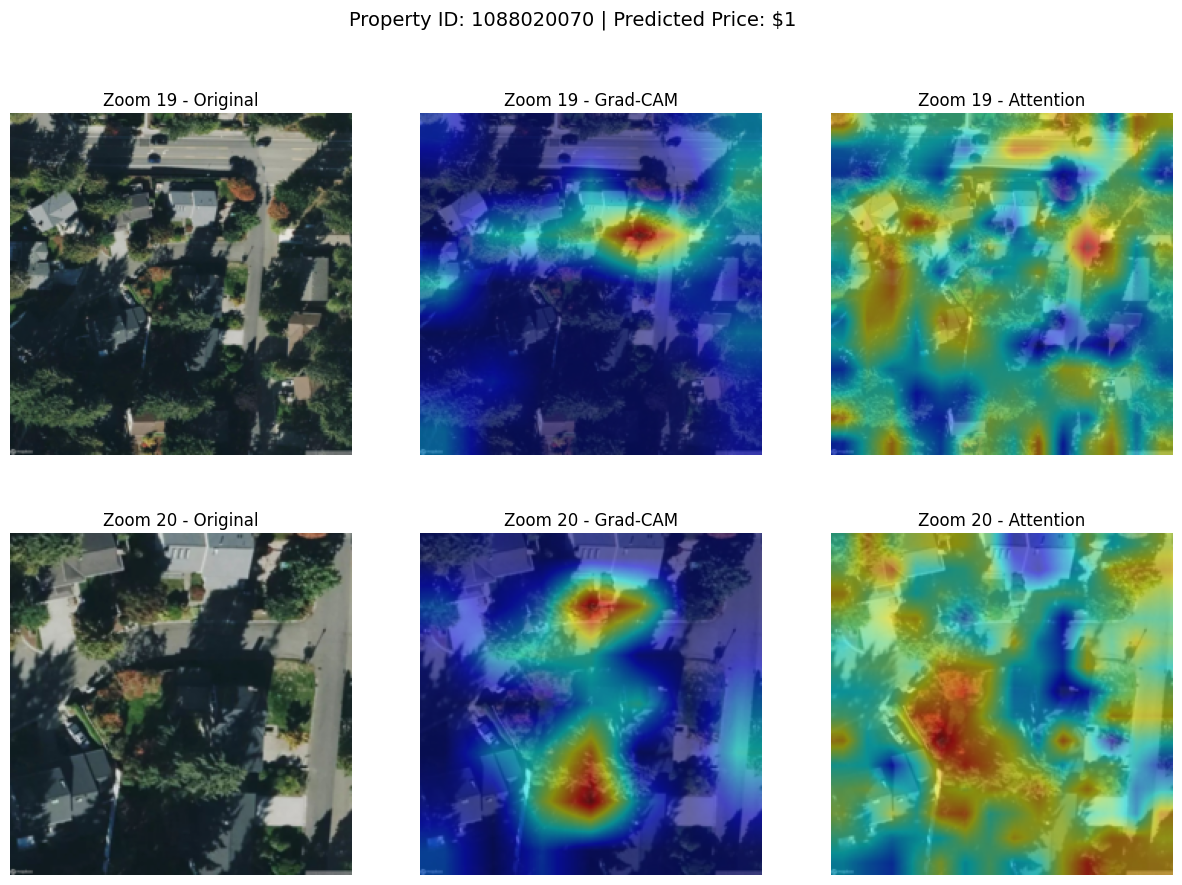

In [19]:
# Cell 20: Generate Explainability for Validation Set
print("Generating explainability visualizations for validation set...")

val_explain_dir = os.path.join(config.EXPLAINABILITY_DIR, 'validation')
os.makedirs(val_explain_dir, exist_ok=True)

# Generate visualizations for all validation samples
model.eval()
saved_count = 0

for idx in tqdm(range(len(val_dataset)), desc="Validation Explainability"):
    img_19, img_20, tabular, target, prop_id = val_dataset[idx]
    
    # Add batch dimension
    img_19 = img_19.unsqueeze(0).to(device)
    img_20 = img_20.unsqueeze(0).to(device)
    tabular = tabular.unsqueeze(0).to(device)
    
    try:
        save_path = visualize_explainability(
            model, img_19, img_20, tabular, prop_id, val_explain_dir, prefix='val'
        )
        saved_count += 1
    except Exception as e:
        print(f"Error for property {prop_id}: {e}")
        continue

print(f"\nSaved {saved_count} validation explainability visualizations to {val_explain_dir}")